# P3P (Perspective-3-Point) in torch : A Step-by-step tutorial with POSEIDON 

## Introduction
Welcome to this interactive Jupyter Notebook!

Pose estimation from minimal geometric constraints plays a central role in 3D computer vision. Among these, the **Perspective-Three-Point** (P3P) problem is a classic: given three 2D-3D point correspondences, estimate the camera's pose. Kneip's method provides a practical and reliable closed-form solution, making it a common choice in pose estimation tasks.

- **Meet `POSEIDON`**, a fast, differentiable PyTorch library implementing Kneip’s P3P algorithm — ideal for real-time, gradient-based learning.

- Built on top of `autoroot`, it leverages differentiable polynomial solvers to bring exact geometry into your training loop.

- Seamless autograd integration means you can embed POSEIDON directly into your loss function — perfect for tasks like training a YOLO model that learns to predict 3D positions, minimizing reprojection or track alignment errors.

Let’s take a look at how POSEIDON combines geometric precision with practical integration into modern pipelines.


In [3]:
# On Colab: install the library
on_colab = "google.colab" in str(get_ipython())
if on_colab:
    import sys  # noqa: avoid having this import removed by pycln

    # install dev version for dev doc, or release version for release doc
    !{sys.executable} -m pip install -U pip
    !{sys.executable} -m pip install git+https://github.com/Pruneeuh/POSEIDON@main#egg=decomon
    # install desired backend (by default torch)
    !{sys.executable} -m pip install "torch"

    # extra librabry used in this notebook
    !{sys.executable} -m pip install "numpy"
    !{sys.executable} -m pip install "cmath"
    !{sys.executable} -m pip install "matplotlib"

Summarizing Kneip PEP Method for a Direct Computation of Absolute Camera Position and Orientation

#### 1. Compute a transformation matrix (T) and the feature vector f3_T in features vectors frame  
$ \space\space\space\space \vec{f_i\_T} = T. \vec{fi} $
#### 2. Compute a transformation matrix (N) and the world point P3_N in the world-point frame  
$ \space\space\space\space P_i\_N = N . (P_i - P_1) $
#### 3. Extract p1 and p2 from P3_N  
$ \space\space\space\space P_3\_N = \begin{pmatrix} p_1 \\ p_2 \\ 0 \end{pmatrix} $
#### 4. Compute d12 and b  
$ \space\space\space\space b = cot \beta = \pm \sqrt{ \frac{1}{1 - cos(\beta)^2} -1 } = \pm \sqrt{ \frac{1}{1 - (\vec{f1}.\vec{f2})^2} -1 }$
#### 5. Compute phi1 and phi2  
$ \space\space\space\space \phi_1 = \frac{(f_3\_T)_x}{(f_3\_T)_z} \space  and \space \phi_2 = \frac{(f_3\_T)_y}{(f_3\_T)_z} $
#### 6. Compute the factors a4,a3,a2,a1 and a0 of polynomial  
$ \space\space\space\space a4 cos^4\theta+a3 cos^3\theta+a2 cos^2\theta + a1 cos\theta +a0 = 0 $
#### 7. Find the real roots of the polynomial (values for cos_teta)  
Using the library [autoroot](https://github.com/Pruneeuh/autoroot) : 
#### 8. For each solutions find the values for cot_alpha  
$ \space\space\space\space cot\alpha = \frac{\frac{\phi_1}{\phi_2}.p1 + cos\theta.p2 - d_{12}.b}{\frac{\phi_1}{\phi_2}.p2 - p1 +d_{12}} $
#### 9. Compute all necessary trigonometric forms of alpha and teta using trigonometric relationships and the restricted parameter domains  
$ \space\space\space\space cos\theta = \real{(root)} \\ 
 \space\space\space\space sin\alpha = \sqrt{ \frac{1}{cot^2\alpha +1}} \\
 \space\space\space\space sin\theta = \pm \sqrt{1 - cos^2\theta} \\ 
 \space\space\space\space cos\alpha = \pm \sqrt{1-sin^2\alpha}  \\ $
#### 10. for each solution, compute C_ and Q  
$ \space\space\space\space C\_N = \begin{pmatrix} 
d_{12}  \space  cos\alpha \space (sin\alpha .b + cos\alpha ) \\
d_{12} \space sin\alpha \space cos\theta \space(sin\alpha .b + cos\alpha ) \\
d_{12} \space sin\alpha \space sin\theta \space (sin\alpha .b + cos\alpha )
\end{pmatrix}
\space\space\space\space
Q = \begin{pmatrix}
-cos\alpha & -sin\alpha \space cos\theta & - sin\alpha \space sin\theta \\
sin\alpha & -cos\alpha \space cos\theta & -cos\alpha \space sin\theta \\
0 & -sin \theta & cos\theta
\end{pmatrix}
$
#### 11. for each solution, compute the absolute camera center C and orientation R  
$ \space\space\space\space  C = P_1 + N^T . C\_N \\
\space\space\space\space R = N^T . Q^T . T $
#### 12. Backproject a fourth point for disambiguation  

Illustration : a faire 

## Using P3P with POSEIDON

Now, let's use your `poseidon` library to compute the positon and rotation matrix of the camera 

First, ensure you have `poseidon` installed : 

In [4]:
# If not already installed, uncomment
# !pip install autoroot_torch

To use the **P3P (Perspective-Three-Point)** method, the following components are required:
#### 1. Three 3D points 
- These are real-world coordinates of three points visible from the camera. 
- Here we are only generating one serie of 3 points for the example (but it is possible to generate tensors the size of a defined batch, see tutorial 2).
- Example : 

3D points in numpy array format:
 [[1.00255836 1.2676066  1.58402029]
 [1.09722345 0.14566632 0.65844161]
 [0.95962723 1.83509652 0.5059897 ]
 [1.05473224 0.62104615 1.94548984]]


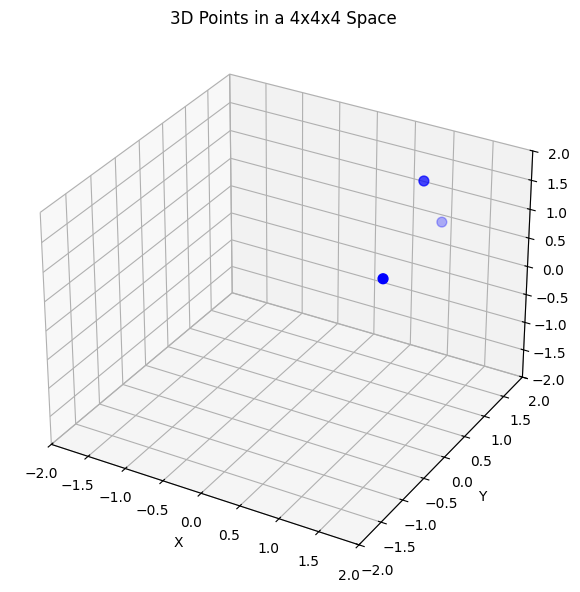

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from poseidon.numpy.utils.before_p3p import generate_points_3D
from poseidon.torch.utils.before_p3p import convert_matrix_numpy_to_batch

points_3D_np = generate_points_3D() # generate 3D points in numpy array format
points_3D = convert_matrix_numpy_to_batch(points_3D_np)  # convert numpy array to batch format

print("3D points in numpy array format:\n", points_3D_np)

# Create of the 3D figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D points
ax.scatter(points_3D_np[:3, 0], points_3D_np[:3, 1], points_3D_np[:3, 2], c='blue', s=50)

# Set axis limits to visualize a 4x4x4 space centered around zero
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_zlim([-2, 2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Points in a 4x4x4 Space')

ax.grid(True)
plt.tight_layout()
plt.show()